# Use Spark for Python to load data and run queries on it.
This notebook is for analysing csv file which consists of all data related to the bird strikes and determine which airport is most dangerous in terms of no of strikes. 

In this project, you'll use the data set from federal aviation administration to do some basic anlytics.


## Table of contents
This notebook contains these main sections:

1. [Load a DataFrame](#Load_a_DataFrame)
2. [Create an SQLContext](#Create_an_SQLContext)
3. [Create a Spark DataFrame](#Create_a_Spark_DataFrame)
4. [Aggregate data after grouping by columns](#Aggregate_data_after_grouping_by_columns)
5. [Operate on columns](#Operate_on_columns)
6. [Run SQL queries from the Spark DataFrame](#Run_SQL_queries_from_the_Spark_DataFrame)

<a id='Load_a_DataFrame'></a>
## 1. Load a DataFrame
A DataFrame is a distributed collection of data that is organized into named columns. The Python pandas DataFrame that you will create will load an external DataFrame called wildlife, which includes observations on the following  variables:

`[, 1]	state 
`[, 2]	airport 
`[, 3]	operator 
`[, 4]	species   `
`[, 5]	incident_month `
`[, 6]	incident_year `
`[, 7]	time_of_day `
`[, 8]	phase_of_flight `
`[, 9]	bird_struck  `
`[,10]	damage_indicated`
`[,11]	aircraft_model`

In [227]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /usr/local/src/bluemix_jupyter_bundle.v37/notebook/lib/python2.7/site-packages
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2d2-d46ffcc1f7970d-97e2e1860657/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2d2-d46ffcc1f7970d-97e2e1860657/.local/lib/python2.7/site-packages (from pixiedust)


In [228]:

from io import StringIO
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  




# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_7dbc96622ee84f0ab15565ea4314506d(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_cedf4e6a1891340c8c0e04e7685eba91588d2fb1','domain': {'id': 'a29033e2409147289a7409fd4387a6eb'},
            'password': 'r,)Jsr3p)!/U==r9'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

wildlife = pd.read_csv(get_object_storage_file_with_credentials_7dbc96622ee84f0ab15565ea4314506d('SparkAssignmentHousing', 'wildlife.csv'))


<a id='Create_an_SQLContext'></a>
## 2. Create an SQLContext
To work with a DataFrame, you need an SQLContext class object, and to create a basic one, all you need is a SparkContext. A SparkContext represents the connection to a Spark cluster, and a SparkContext class object named sc, which has been created for you, is used to initialize the SQLContext:

In [229]:
sqlContext = SQLContext(sc)

<a id='Create_a_Spark_DataFrame'></a>
## 3. Create a Spark DataFrame
Using the SQLContext class object and the loaded local DataFrame, create a Spark DataFrame and print the schema, or structure, of the DataFrame:

In [230]:
sdf = sqlContext.createDataFrame(wildlife) 
sdf.printSchema()

root
 |-- state: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- operator: string (nullable = true)
 |-- species : string (nullable = true)
 |-- incident_month: long (nullable = true)
 |-- incident_year: long (nullable = true)
 |-- time_of_day: double (nullable = true)
 |-- phase_of_flight: double (nullable = true)
 |-- SKY: double (nullable = true)
 |-- bird_struck: string (nullable = true)
 |-- damage_indicated: boolean (nullable = true)
 |-- aircraft_model: string (nullable = true)



Display the content of the Spark DataFrame:

In [231]:
sdf.show(32)

+-----+--------------------+--------------------+--------------------+--------------+-------------+-----------+---------------+----+-----------+----------------+--------------+
|state|             airport|            operator|            species |incident_month|incident_year|time_of_day|phase_of_flight| SKY|bird_struck|damage_indicated|aircraft_model|
+-----+--------------------+--------------------+--------------------+--------------+-------------+-----------+---------------+----+-----------+----------------+--------------+
|   CA|  MONTEREY PENINSULA|             UNKNOWN|        Barn swallow|             4|         2016|        NaN|            NaN| NaN|          1|           false|       UNKNOWN|
|   CA|  METRO OAKLAND INTL|             UNKNOWN|  Western meadowlark|             4|         2016|        NaN|            NaN| NaN|          1|           false|       UNKNOWN|
|   CA|   ONTARIO INTL ARPT|  SOUTHWEST AIRLINES|Unknown bird - small|             4|         2016|       null|    

Try different ways of retrieving subsets of the data. For example, get the first 5 values in the **mpg** column:

In [232]:
sdf.select('airport').show(5)

+--------------------+
|             airport|
+--------------------+
|  MONTEREY PENINSULA|
|  METRO OAKLAND INTL|
|   ONTARIO INTL ARPT|
|  METRO OAKLAND INTL|
|PALO ALTO ARPT OF...|
+--------------------+
only showing top 5 rows



Filter the DataFrame to retain only rows where incidents happened after april:

In [233]:
sdf.filter(sdf['incident_month'] > 2).show()

+-----+--------------------+------------------+--------------------+--------------+-------------+-----------+---------------+----+-----------+----------------+--------------+
|state|             airport|          operator|            species |incident_month|incident_year|time_of_day|phase_of_flight| SKY|bird_struck|damage_indicated|aircraft_model|
+-----+--------------------+------------------+--------------------+--------------+-------------+-----------+---------------+----+-----------+----------------+--------------+
|   CA|  MONTEREY PENINSULA|           UNKNOWN|        Barn swallow|             4|         2016|        NaN|            NaN| NaN|          1|           false|       UNKNOWN|
|   CA|  METRO OAKLAND INTL|           UNKNOWN|  Western meadowlark|             4|         2016|        NaN|            NaN| NaN|          1|           false|       UNKNOWN|
|   CA|   ONTARIO INTL ARPT|SOUTHWEST AIRLINES|Unknown bird - small|             4|         2016|       null|           null|

<a id='Aggregate_data_after_grouping_by_columns'></a>
## 4. Aggregate data after grouping by columns
Spark DataFrames support a number of common functions to aggregate data after grouping.

In [234]:
sdf.groupby(['airport'])\
.agg({"bird_struck": "sum"})\
.show()

+--------------------+----------------+
|             airport|sum(bird_struck)|
+--------------------+----------------+
|SANTA BARBARA MUN...|             7.0|
|         OXNARD ARPT|             1.0|
|PALMDALE USAF PLA...|             1.0|
|SACRAMENTO EXECUT...|             1.0|
|PALO ALTO ARPT OF...|             2.0|
|FRESNO YOSEMITE INTL|             2.0|
|SAN BERNARDINO IN...|             2.0|
| BRACKETT FIELD ARPT|             1.0|
|HAYWARD EXECUTIVE...|             1.0|
|   REDDING MUNICIPAL|             1.0|
|RIVERSIDE MUNICIP...|             1.0|
|LIVERMORE MUNICIP...|             1.0|
|JOHN WAYNE-ORANGE...|            13.0|
| MC CLELLAN AIRFIELD|             2.0|
|           CAMARILLO|             1.0|
|     SAN CARLOS ARPT|             1.0|
|  METRO OAKLAND INTL|            28.0|
|NORTH ISLAND NAS ...|             1.0|
|   PALM SPRINGS INTL|             1.0|
|SACRAMENTO MATHER...|             2.0|
+--------------------+----------------+
only showing top 20 rows



You can also sort the output from the aggregation to determine the most popular cylinder configuration in the DataFrame:

In [235]:
bird_strikes = sdf.groupby(['airport'])\
.agg({"bird_struck": "count"})\
.sort("count(bird_struck)", ascending=False)\
.show(10)

+--------------------+------------------+
|             airport|count(bird_struck)|
+--------------------+------------------+
|    LOS ANGELES INTL|                33|
|     SACRAMENTO INTL|                30|
|  METRO OAKLAND INTL|                29|
|SAN FRANCISCO INT...|                16|
|JOHN WAYNE-ORANGE...|                13|
|   ONTARIO INTL ARPT|                10|
|NORMAN Y. MINETA ...|                 9|
|LONG BEACH-DAUGH FLD|                 9|
|       BOB HOPE ARPT|                 8|
|      SAN DIEGO INTL|                 7|
+--------------------+------------------+
only showing top 10 rows



<a id='Run_SQL_queries_from_the_Spark_DataFrame'></a>
## 5. Run SQL queries from the Spark DataFrame
You can register a Spark DataFrame as a temporary table and then run SQL queries over the data. The `sql` function enables an application to run SQL queries programmatically and returns the result as a DataFrame:

In [236]:
sdf.registerTempTable("airdata")

aircrafts = sqlContext.sql("SELECT airport, operator,aircraft_model FROM airdata WHERE aircraft_model like 'B-%'")
aircrafts.show()    

+--------------------+------------------+--------------+
|             airport|          operator|aircraft_model|
+--------------------+------------------+--------------+
|   ONTARIO INTL ARPT|SOUTHWEST AIRLINES|     B-737-700|
|  METRO OAKLAND INTL|SOUTHWEST AIRLINES|     B-737-700|
|   PALM SPRINGS INTL|   ALASKA AIRLINES|     B-737-700|
|    LOS ANGELES INTL|    CHINA AIRLINES|     B-777-300|
|NORMAN Y. MINETA ...|   UNITED AIRLINES|     B-737-900|
|     SACRAMENTO INTL|SOUTHWEST AIRLINES|     B-737-300|
|     SACRAMENTO INTL|SOUTHWEST AIRLINES|     B-737-300|
|  METRO OAKLAND INTL|SOUTHWEST AIRLINES|     B-737-700|
|SAN FRANCISCO INT...|   UNITED AIRLINES|     B-737-900|
|    LOS ANGELES INTL|SOUTHWEST AIRLINES|     B-737-300|
|  METRO OAKLAND INTL|SOUTHWEST AIRLINES|     B-737-700|
|     SACRAMENTO INTL|   UNITED AIRLINES|     B-737-900|
|  METRO OAKLAND INTL|SOUTHWEST AIRLINES|     B-737-300|
|  METRO OAKLAND INTL|SOUTHWEST AIRLINES|     B-737-300|
|     SACRAMENTO INTL|SOUTHWEST

<a id='Data Visualization through graph'></a>
## 7. Datavisualization through graph
you can use the pyplot libraries to visualize the reports in the form of the bargraphs.

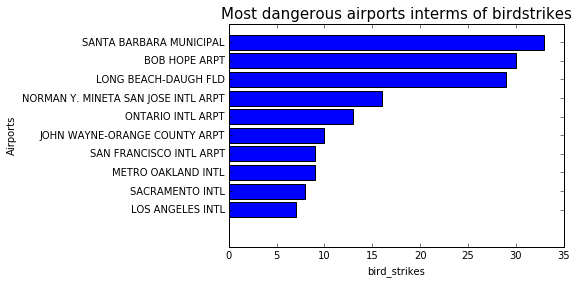

In [237]:
chart = sdf.groupby(['airport']).count().sort(('count'), ascending= False).limit(10).toPandas()
pos = range(10)
plt.barh(pos,chart.sort_values(by='count', ascending=True)['count'], ecolor='r', align='center')
plt.xlabel('bird_strikes')
plt.ylabel('Airports')
plt.title('Most dangerous airports interms of birdstrikes', size=15)
plt.yticks(pos, chart['airport'])
plt.show()